In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

from local_utilities import load_as_df

In [118]:
stock_list = load_as_df('select * from base_stocks where market = "主板"')
stock_list = stock_list.set_index('ts_code')
code_list = list(stock_list.index)

s1,s2,s3,s4 = code_list[:500], code_list[500:1000], code_list[1000:1500], code_list[1500:]

In [69]:
ts_code = s1[0]
def find_spec(ts_code, start_day='2019-01-01'):
    df_days = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    chg_times, vol_times = 0, 0
    try:
        if df_days.shape[0] > 0:
            spec_arr = pd.qcut(np.abs(df_days.pct_chg), 10, duplicates='drop').value_counts()
            spec_chg = spec_arr.keys()[0].left
            spec_vol = pd.qcut(np.abs(df_days.vol), 10).value_counts().keys()[0].left
            chg_times, vol_times = df_days[-10:][df_days.pct_chg > spec_bar].shape[0], df_days[-10:][df_days.vol > spec_vol].shape[0]
    except Exception as e:
        print('ts_code:{}, err:{}'.format(ts_code, e))
    return (ts_code, chg_times, vol_times)

In [70]:
spec_list = []
for s in s1:
    spec_list.append(find_spec(s))

In [127]:
df_spec = pd.DataFrame(spec_list, columns=('ts_code', 'chg_times', 'vol_times'))
df_spec = df_spec.set_index('ts_code')
df_spec = df_spec[(df_spec.chg_times > 2) & (df_spec.vol_times > 1)].sort_values(by='chg_times', ascending=False)
df_spec = df_spec.join(stock_list)

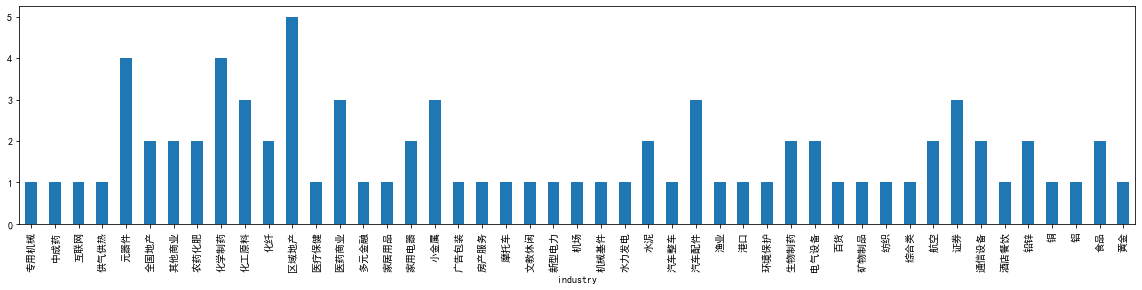

In [147]:
df_spec.groupby('industry', as_index=True).count()['symbol'].plot(kind='bar', figsize=(20,4))

In [97]:
# df_spec.sort_values(by='chg_times', ascending=False)


In [98]:
df_spec[:10]

,chg_times,vol_times
ts_code,,
000698.SZ,7,10
000411.SZ,7,6
000153.SZ,6,10
000421.SZ,6,10
000710.SZ,6,7
000603.SZ,5,8
000691.SZ,5,8
000518.SZ,5,3
000501.SZ,5,10


In [123]:
df_spec[:10]

,chg_times,vol_times
ts_code,,
000698.SZ,7,10
000411.SZ,7,6
000153.SZ,6,10
000421.SZ,6,10
000710.SZ,6,7
000603.SZ,5,8
000691.SZ,5,8
000518.SZ,5,3
000501.SZ,5,10


In [124]:
# pd.merge(df_spec, stock_list, how='inner')
stock_list[:10]

,symbol,name,area,industry,market,list_date
ts_code,,,,,,
000001.SZ,000001,平安银行,深圳,银行,主板,19910403
000002.SZ,000002,万科A,深圳,全国地产,主板,19910129
000004.SZ,000004,国农科技,深圳,互联网,主板,19910114
000005.SZ,000005,世纪星源,深圳,环境保护,主板,19901210
000006.SZ,000006,深振业A,深圳,区域地产,主板,19920427
000007.SZ,000007,全新好,深圳,酒店餐饮,主板,19920413
000008.SZ,000008,神州高铁,北京,运输设备,主板,19920507
000009.SZ,000009,中国宝安,深圳,综合类,主板,19910625
000010.SZ,000010,美丽生态,深圳,建筑工程,主板,19951027


In [125]:
# pd.merge(df_spec, stock_list, how='inner')
df_spec.join(stock_list)[['name', '']]

,chg_times,vol_times,symbol,name,area,industry,market,list_date
ts_code,,,,,,,,
000698.SZ,7,10,000698,沈阳化工,辽宁,化工原料,主板,19970220
000411.SZ,7,6,000411,英特集团,浙江,医药商业,主板,19960716
000153.SZ,6,10,000153,丰原药业,安徽,化学制药,主板,20000920
000421.SZ,6,10,000421,南京公用,江苏,供气供热,主板,19960806
000710.SZ,6,7,000710,贝瑞基因,四川,医疗保健,主板,19970422
...,...,...,...,...,...,...,...,...
000686.SZ,3,3,000686,东北证券,吉林,证券,主板,19970227
000697.SZ,3,6,000697,炼石航空,陕西,航空,主板,19970325
000703.SZ,3,6,000703,恒逸石化,广西,化纤,主板,19970328


In [83]:
def visual_trend(ts_code, start_day='2019-01-01'):
    tf_trend = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    tf_trend[:12][['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))

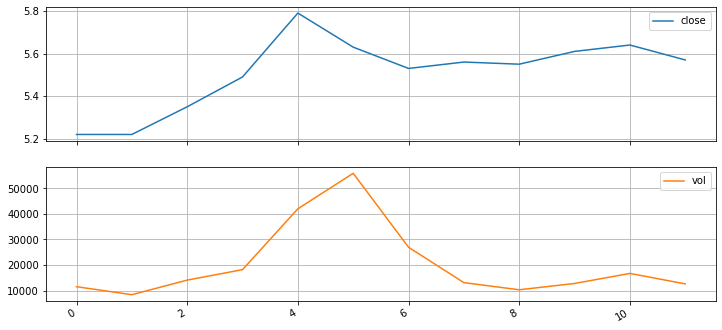

In [87]:
visual_trend('000153.SZ')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000245E1B6BA60>],
      dtype=object)

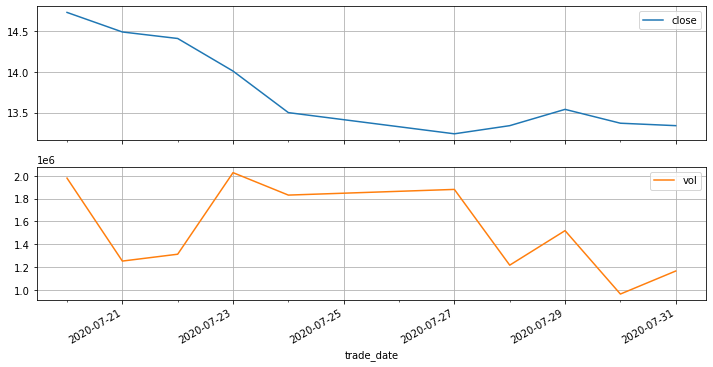

In [52]:
df_sample[['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))